In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from SCFInitialGuess.utilities.dataset import Dataset

S, P = np.load("butadien/dataset.npy")
dim = 26
dataset = Dataset(S, P)

[-] 2018-03-20 15:10:18: Data set initialized. Mean value std: 0.00872792525661018


## Plot utuls

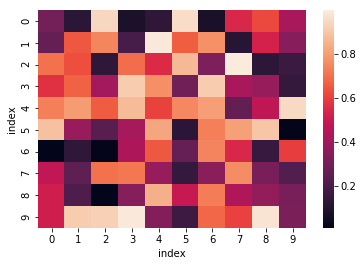

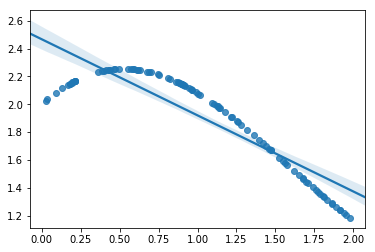

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

cmap = plt.get_cmap('PuRd')# oder RdPu

def matrix_error(error, xlabel="index", ylabel="index", **kwargs):
    
    ax = sns.heatmap(error, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax
    

def prediction_scatter(actual, predicted):
    fig = plt.figure()
    sns.regplot(x=actual, y=predicted)
    
matrix_error(np.random.rand(10, 10))
x = np.random.rand(100) * 2
y = x + np.cos(x)*2
prediction_scatter(x, y)

plt.show()


## Training different costs

In [38]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-03-20 15:45:43: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-20 15:45:43: Setting up the training in the target graph ...
[-] 2018-03-20 15:45:43: network ...
[-] 2018-03-20 15:45:43: error function ...
[-] 2018-03-20 15:45:43: cost function ...
[-] 2018-03-20 15:45:43: training step
[-] 2018-03-20 15:45:44: Starting network training ...
[ ] 2018-03-20 15:45:44: Validation cost: 5.78083E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-20 15:45:44: Validation cost: 6.10391E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-20 15:45:45: Validation cost: 2.19108E-05. Diff to prev.: 3.9E-05
[ ] 2018-03-20 15:45:45: Validation cost: 1.30595E-05. Diff to prev.: 8.9E-06
[ ] 2018-03-20 15:45:46: Validation cost: 1.09741E-05. Diff to prev.: 2.1E-06
[ ] 2018-03-20 15:45:47: Validation cost: 1.21171E-05. Diff to prev.: 1.1E-06
[ ] 2018-03-20 15:45:47: Validation cost: 2.93813E-05. Diff to prev.: 1.7E-05
[ ] 2018-03-20 15:45:48: Validation cost: 7.93677E-06. Diff to prev.: 

### Enforce hermiticity

In [46]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.norm(reshaped - transposed, axis=(1,2))

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=1e-7)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=5e-8
)
graph_sym = trainer_sym.graph
        

[-] 2018-03-20 15:50:16: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-20 15:50:16: Setting up the training in the target graph ...
[-] 2018-03-20 15:50:16: network ...
[-] 2018-03-20 15:50:16: error function ...
[-] 2018-03-20 15:50:16: cost function ...
[-] 2018-03-20 15:50:16: training step
[-] 2018-03-20 15:50:16: Starting network training ...
[ ] 2018-03-20 15:50:16: Validation cost: 5.81171E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-20 15:50:16: Validation cost: 6.01942E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-20 15:50:17: Validation cost: 2.26937E-05. Diff to prev.: 3.8E-05
[ ] 2018-03-20 15:50:18: Validation cost: 1.28039E-05. Diff to prev.: 9.9E-06
[ ] 2018-03-20 15:50:18: Validation cost: 1.18376E-05. Diff to prev.: 9.7E-07
[ ] 2018-03-20 15:50:19: Validation cost: 1.54315E-05. Diff to prev.: 3.6E-06
[ ] 2018-03-20 15:50:19: Validation cost: 9.14064E-06. Diff to prev.: 6.3E-06
[ ] 2018-03-20 15:50:20: Validation cost: 9.46398E-06. Diff to prev.: 

### Enforce idempotency

In [56]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        squared = tf.matmul(reshaped, reshaped)
        
        return tf.norm(reshaped - squared, axis=(1,2))

    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-7)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=5e-8
)
graph_idem = trainer.graph

[-] 2018-03-20 15:59:40: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-20 15:59:40: Setting up the training in the target graph ...
[-] 2018-03-20 15:59:40: network ...
[-] 2018-03-20 15:59:40: error function ...
[-] 2018-03-20 15:59:40: cost function ...
[-] 2018-03-20 15:59:41: training step
[-] 2018-03-20 15:59:41: Starting network training ...
[ ] 2018-03-20 15:59:41: Validation cost: 5.79574E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-20 15:59:41: Validation cost: 6.55573E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-20 15:59:42: Validation cost: 2.27925E-05. Diff to prev.: 4.3E-05
[ ] 2018-03-20 15:59:42: Validation cost: 1.70403E-05. Diff to prev.: 5.8E-06
[ ] 2018-03-20 15:59:43: Validation cost: 1.44913E-05. Diff to prev.: 2.5E-06
[ ] 2018-03-20 15:59:43: Validation cost: 4.61338E-05. Diff to prev.: 3.2E-05
[ ] 2018-03-20 15:59:44: Validation cost: 1.17468E-05. Diff to prev.: 3.4E-05
[ ] 2018-03-20 15:59:44: Validation cost: 9.46924E-06. Diff to prev.: 

In [ ]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IntervalPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IntervalPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_measure(self, output_tensor):
        
        output_tensor += (tf.sigmn(tf.abs(output_tensor)) + 1) * pow(output_tensor, 4)
        
        return tf.norm(reshaped - squared, axis=(1,2))

    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IntervalPenalty(coupling=1e-7)
)

trainer.setup()
network_int, sess_int = trainer.train(
    dataset,
    convergence_threshold=5e-8
)
graph_int = trainer.graph

## Analysis

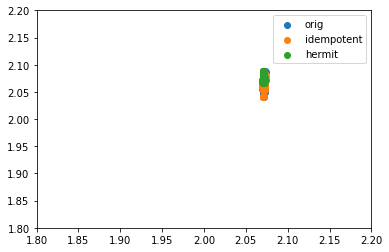

In [61]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

lower = 1.8
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()